In [1]:
% matplotlib inline
from pymongo import MongoClient
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import networkx as nx
import nltk
from langdetect import detect
from langdetect import detect_langs
from langdetect import DetectorFactory
from nltk.tokenize import RegexpTokenizer  
from stop_words import get_stop_words  
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora, models  
import gensim  


D:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
mongo_username = 'Campione'
mongo_password = 'veTRxJL29lpKWwPn'
mongo_url = 'mongodb://%s:%s@cluster0-shard-00-01-i6gcp.mongodb.net:27017/admin' % (
            mongo_username, mongo_password)
client = MongoClient(mongo_url,ssl=True,replicaSet='Cluster0-shard-0',authSource='admin')
info = client.server_info()  # Forces a call.
# print(info)
print(client.database_names())

['gitdb', 'gitdbPro', 'guidebook', 'test', 'admin', 'local']


In [3]:
db = client.gitdbPro
repos = db.repos
descriptions = repos.distinct('description')
df = pd.DataFrame(descriptions)
df.head()

,0
0,How to be low-level programmer
1,Import OpenStreetMap data into Unreal Engine 4
2,react-native template to target multiple platf...
3,Connect your App to Multiple Messaging Channel...
4,Proto Actor - Ultra fast distributed actors fo...


In [4]:
df[0]

0                           How to be low-level programmer
1           Import OpenStreetMap data into Unreal Engine 4
2        react-native template to target multiple platf...
3        Connect your App to Multiple Messaging Channel...
4        Proto Actor - Ultra fast distributed actors fo...
5                用rxjava简单封装了指纹识别，并实现对生命周期的自动绑定，顺便撸了一个指纹控件
6                                   pagehelper-spring-boot
7            📅 A date picker components for ionic2 ／ionic3
8        Track prices on Amazon and receive email alert...
9        Advanced web based trading client for the Stel...
10                                  Join our slack channel
11       An Elm-based prototype to help designers build...
12       Can neural networks transliterate Romaji into ...
13                              A repo with small projects
14               Go - CQRS / Event Sourcing made easy - Go
15                                RNN Tutorial for Artists
16       A macOS app to convert JSON objects into Swift.

In [5]:
DetectorFactory.seed = 0

In [6]:
cn_text_list = []
en_text_list = []
for item in df[0]:
    try:
        if detect(str(item)) == 'zh-cn':
            cn_text_list.append(item)
        else:
            en_text_list.append(item)
    except Exception as e:
        print(str(e))

No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.


In [8]:
len(cn_text_list)

697

In [9]:
len(en_text_list)

11143

In [10]:
df_cn = pd.DataFrame({'text':cn_text_list})
print(df_cn.head())
df_cn.to_csv('cn_text')

                                                text
0          用rxjava简单封装了指纹识别，并实现对生命周期的自动绑定，顺便撸了一个指纹控件
1           每周一篇，内容精简，不咸不淡，期盼探讨。微信公众号：芋道源码【纯源码分享公众号】
2                                  iOS即时通讯，从入门到“放弃”？
3  『假装看天气』─── 天气预报 & 公交查询 & 资讯阅读 & 妹纸福利 的 Android...
4                                         微信小程序－日历 📅


In [11]:
df_en = pd.DataFrame({'text':en_text_list})
print(df_en.head())
df_en.to_csv('en_text')

                                                text
0                     How to be low-level programmer
1     Import OpenStreetMap data into Unreal Engine 4
2  react-native template to target multiple platf...
3  Connect your App to Multiple Messaging Channel...
4  Proto Actor - Ultra fast distributed actors fo...


In [12]:
# GENERATE LDA Model
import re

# list for tokenized documents in loop  
texts = []
tokenizer = RegexpTokenizer(r'\w+')
# create English stop words list
en_stop = get_stop_words('en')
# Create p_stemmer of class PorterStemmer
stemmer = SnowballStemmer("english")

# loop through document list  
for i in en_text_list:
    if i is not None:
        raw = i.lower()
        # clean and tokenize document string
        tokens = tokenizer.tokenize(raw)
        
        # remove stop words from tokens  
        stopped_tokens = [i for i in tokens if not i in en_stop]
        
        # remove all numbers
        without_numbers = [re.sub(r'\d+', '', i) for i in stopped_tokens]
        
        # stem tokens
        stemmed_tokens = [stemmer.stem(i) for i in without_numbers]
        
        # add tokens to list
        texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
      
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)

In [13]:
for topic in ldamodel.print_topics(num_words=5, num_topics=20):
    print(topic)

(0, '0.055*"go" + 0.027*"video" + 0.024*"written" + 0.021*"rust" + 0.020*"librari"')
(1, '0.257*"" + 0.033*"https" + 0.028*"github" + 0.025*"code" + 0.024*"com"')
(2, '0.071*"vue" + 0.053*"js" + 0.019*"compon" + 0.018*"plugin" + 0.015*"base"')
(3, '0.027*"file" + 0.026*"system" + 0.021*"packag" + 0.019*"find" + 0.018*"instal"')
(4, '0.068*"learn" + 0.066*"implement" + 0.045*"network" + 0.032*"deep" + 0.031*"pytorch"')
(5, '0.028*"document" + 0.016*"cach" + 0.016*"attack" + 0.014*"minim" + 0.010*"advanc"')
(6, '0.023*"test" + 0.023*"tool" + 0.021*"secur" + 0.017*"kubernet" + 0.016*"devic"')
(7, '0.025*"run" + 0.025*"script" + 0.017*"relat" + 0.016*"docker" + 0.015*"function"')
(8, '0.042*"anim" + 0.035*"perform" + 0.032*"imag" + 0.028*"high" + 0.022*"extens"')
(9, '0.022*"search" + 0.022*"laravel" + 0.022*"templat" + 0.019*"project" + 0.019*"uniti"')
(10, '0.061*"list" + 0.039*"time" + 0.037*"awesom" + 0.031*"resourc" + 0.029*"curat"')
(11, '0.033*"line" + 0.031*"command" + 0.024*"light

In [12]:
from gensim.models.wrappers import LdaMallet

mallet_path = r"/mallet-2.0.8/bin/mallet"
model = LdaMallet(mallet_path, corpus, num_topics=10, id2word=dictionary)
print(model[corpus])

CalledProcessError: Command '/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\WENXUA~1\AppData\Local\Temp\2aff1e_corpus.txt --output C:\Users\WENXUA~1\AppData\Local\Temp\2aff1e_corpus.mallet' returned non-zero exit status 1.

In [14]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
19     7.591612        1       1 -0.178614 -0.081473
4      7.451771        1       2 -0.038359  0.337281
15     6.737192        1       3 -0.163516 -0.042537
18     6.681099        1       4  0.189537 -0.056884
16     6.291097        1       5 -0.121172  0.039144
1      5.637125        1       6  0.195456  0.091886
6      5.571969        1       7 -0.082364 -0.058549
11     5.051179        1       8 -0.133529 -0.021562
2      4.767193        1       9 -0.070110 -0.058031
8      4.705801        1      10 -0.056673  0.025832
12     4.631585        1      11  0.056065 -0.048573
0      4.525970        1      12 -0.052982 -0.026060
10     4.411850        1      13  0.043690 -0.025589
13     4.331386        1      14  0.013161  0.064963
7      4.294379        1      15  0.026015  0.052974
9      3.644795        1      16  0.062257 -0.045363
14     3.600752        1      17  0.119112 -0.109812
17     3.579819        1      18  0.011470  0.025679
3      3.279130        1      19  0.086951 -0.068187
5      3.214288        1      20  0.093604  0.004859, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
3     Default  1272.000000              1272.000000  30.0000  30.0000
16    Default   520.000000       react   520.000000  29.0000  29.0000
114   Default   428.000000       learn   428.000000  28.0000  28.0000
100   Default   442.000000   implement   442.000000  27.0000  27.0000
20    Default   440.000000         app   440.000000  26.0000  26.0000
178   Default   286.000000         vue   286.000000  25.0000  25.0000
176   Default   302.000000          js   302.000000  24.0000  24.0000
53    Default   280.000000     network   280.000000  23.0000  23.0000
484   Default   226.000000        list   226.000000  22.0000  22.0000
39    Default   330.000000      compon   330.000000  21.0000  21.0000
80    Default   240.000000       sourc   240.000000  20.0000  20.0000
31    Default   238.000000          go   238.000000  19.0000  19.0000
14    Default   230.000000       nativ   230.000000  18.0000  18.0000
24    Default   197.000000        open   197.000000  17.0000  17.0000
113   Default   201.000000        deep   201.000000  16.0000  16.0000
187   Default   171.000000        anim   171.000000  15.0000  15.0000
1263  Default   194.000000     pytorch   194.000000  14.0000  14.0000
152   Default   258.000000        imag   258.000000  13.0000  13.0000
143   Default   435.000000     android   435.000000  12.0000  12.0000
217   Default   191.000000      server   191.000000  11.0000  11.0000
225   Default   299.000000         api   299.000000  10.0000  10.0000
62    Default   149.000000      design   149.000000   9.0000   9.0000
132   Default   590.000000     librari   590.000000   8.0000   8.0000
186   Default   143.000000        time   143.000000   7.0000   7.0000
272   Default   156.000000       https   156.000000   6.0000   6.0000
373   Default   139.000000     collect   139.000000   5.0000   5.0000
513   Default   138.000000      awesom   138.000000   4.0000   4.0000
289   Default   138.000000     perform   138.000000   3.0000   3.0000
115   Default   163.000000      machin   163.000000   2.0000   2.0000
627   Default   162.000000  tensorflow   162.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2806  Topic20    16.843155     snippet    17.671953   3.3895  -5.0774
1046  Topic20    16.494633       insid    17.323431   3.3885  -5.0983
2241  Topic20    14.852402       annot    15.681199   3.3833  -5.2031
459   Topic20    14.812152        usag    15.640949   3.3831  -5.2059
1256  Topic20    14.231320      consol    15.060118   3.3810  -5.2459
9050  Topic20    14.088305       minut    14.917102   3.3804  -5.2560
1145  Topic20    13.814722      orient    14.643519   3.3793 

In [15]:
# SKLEARN LEARN LDA
from __future__ import print_function
from time import time
from random import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 7000
n_features = 100
n_components = 5
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [16]:
# shuffle the data
en_shuffle = en_text_list
shuffle(en_shuffle)
print(en_shuffle)
len(en_shuffle)

['PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation', 'An Android base app with loads of cool libraries/configuration', 'Microsoft Graph Engine', 'Elasticsearch Java API 手册', "The react-native UI Kit you've been looking for.", 'A pedagogical implementation of Autograd', 'Tiny library for building reactive, spreadsheet-like calculations in JavaScript', 'C string utils library (STB style, header-only).', 'ART module for a built-in enabled Xposed firmware based on AOSP 7', 'Add CSS animations to delight users as they scroll down.', '个人网站即时到账收款解决方案 / Personal website instant payment solution', 'OS X mostly ignores the M4/M5 mouse buttons, commonly used for navigation. Third-party apps can bind them to ⌘+[ and ⌘+], but this only works in a small number of apps and feels janky. With this tool, your side buttons will simulate 3-finger swipes, allowing you to navigate almost any window with a history. As seen in the Logitech MX Master!', "Kaspersky's GReAT KLara", 'E

11143

In [17]:
# Get data sample
en_samples = en_shuffle[:n_samples]
len(en_samples)

7000

In [18]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(en_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
dtm_tf = tf_vectorizer.fit_transform(en_samples)
# tfid_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(en_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.112s.
Extracting tf features for LDA...
done in 0.191s.


In [19]:
print(dtm_tf.shape)
print(dtm_tf)
print(dtm_tfidf.shape)
print(dtm_tfidf)

(7000, 100)
  (0, 49)	1
  (0, 23)	1
  (1, 3)	1
  (1, 1)	1
  (3, 2)	1
  (3, 42)	1
  (4, 89)	1
  (4, 60)	1
  (4, 77)	1
  (5, 40)	1
  (6, 43)	1
  (6, 52)	1
  (6, 10)	1
  (6, 50)	1
  (7, 50)	1
  (8, 8)	1
  (8, 11)	1
  (9, 20)	1
  (11, 87)	1
  (11, 6)	2
  (13, 29)	1
  (13, 6)	1
  (14, 95)	1
  (14, 8)	1
  (15, 11)	1
  :	:
  (6984, 71)	1
  (6985, 0)	1
  (6985, 40)	1
  (6986, 93)	1
  (6986, 80)	1
  (6986, 71)	1
  (6987, 70)	1
  (6988, 17)	1
  (6989, 99)	1
  (6989, 4)	1
  (6991, 34)	1
  (6992, 65)	1
  (6993, 91)	1
  (6993, 51)	1
  (6993, 22)	1
  (6993, 43)	1
  (6993, 50)	1
  (6994, 47)	1
  (6994, 13)	1
  (6995, 13)	1
  (6996, 13)	1
  (6997, 78)	1
  (6997, 13)	1
  (6998, 73)	1
  (6998, 48)	1
(7000, 100)
  (0, 23)	0.7446762406722413
  (0, 49)	0.6674258734707984
  (1, 1)	0.674987704112041
  (1, 3)	0.7378289769977564
  (3, 42)	0.7551238229607553
  (3, 2)	0.6555821931666037
  (4, 77)	0.50342536486632
  (4, 60)	0.5872079289267194
  (4, 89)	0.6338373215698219
  (5, 40)	1.0
  (6, 50)	0.388866219631926


In [20]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(dtm_tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=7000 and n_features=100...
done in 0.217s.

Topics in NMF model (Frobenius norm):
Topic #0: library python javascript lightweight data fast swift like client ui text api ios platform image java powerful support create server
Topic #1: code source learning 2017 https github open com project model deep language server tool text plugin projects line javascript programming
Topic #2: react native app components component ios create web apps build ui built like api use design js development application list
Topic #3: android app ios view kotlin use project client design java plugin easy ui framework powerful native apps video support file
Topic #4: simple based using learning implementation tool js framework deep vue python pytorch web data tensorflow api machine project networks network

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=7000 and n_features=100...
done in 0.28

In [21]:
# print(lda.components_)
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.sklearn.prepare(lda, dtm_tfidf, tf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      22.530399        1       1  0.397998 -0.022127
2      22.222786        1       2  0.169124  0.336215
3      21.330329        1       3 -0.349359 -0.202052
1      17.295528        1       4 -0.315116  0.282285
0      16.620958        1       5  0.097353 -0.394321, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
77    Default  216.000000           react  216.000000  30.0000  30.0000
1     Default  198.000000         android  198.000000  29.0000  29.0000
13    Default  178.000000            code  178.000000  28.0000  28.0000
83    Default  142.000000           swift  142.000000  27.0000  27.0000
80    Default  166.000000          simple  166.000000  26.0000  26.0000
2     Default  137.000000             api  137.000000  25.0000  25.0000
49    Default  142.000000        learning  142.000000  24.0000  24.0000
50    Default  231.000000         library  231.000000  23.0000  23.0000
3     Default  138.000000             app  138.000000  22.0000  22.0000
60    Default  115.000000          native  115.000000  21.0000  21.0000
32    Default  134.000000       framework  134.000000  20.0000  20.0000
44    Default  125.000000              js  125.000000  19.0000  19.0000
81    Default  105.000000          source  105.000000  18.0000  18.0000
41    Default  179.000000             ios  179.000000  17.0000  17.0000
8     Default  167.000000           based  167.000000  16.0000  16.0000
40    Default  119.000000  implementation  119.000000  15.0000  15.0000
55    Default   97.000000            list   97.000000  14.0000  14.0000
87    Default  120.000000            tool  120.000000  13.0000  13.0000
66    Default   96.000000            open   96.000000  12.0000  12.0000
97    Default  114.000000             web  114.000000  11.0000  11.0000
95    Default  106.000000             vue  106.000000  10.0000  10.0000
22    Default  105.000000            data  105.000000   9.0000   9.0000
75    Default  104.000000          python  104.000000   8.0000   8.0000
79    Default   82.000000          server   82.000000   7.0000   7.0000
7     Default   79.000000         awesome   79.000000   6.0000   6.0000
89    Default   78.000000              ui   78.000000   5.0000   5.0000
18    Default   80.000000      components   80.000000   4.0000   4.0000
17    Default   78.000000       component   78.000000   3.0000   3.0000
90    Default   92.000000             use   92.000000   2.0000   2.0000
92    Default  158.000000           using  158.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
25     Topic5   55.999470     development   56.460206   1.7863  -3.1078
78     Topic5   52.324013       resources   52.783604   1.7858  -3.1757
46     Topic5   50.737303      kubernetes   51.198459   1.7855  -3.2065
48     Topic5   44.456625         laravel   44.920343   1.7841  -3.3386
88     Topic5   44.089001           tools   44.552807   1.7840  -3.3469
91     Topic5   39.045380            user   39.544213   1.7818  -3.4684
71     Topic5   20.305212        powerful   42.415767   1.0579  -4.1223
6      Topic5   16.916002            apps   54.991501   0.6156  -4.3049
14     Topic5   15.339319      collection   56.564240   0.4895  -4.4027
57     Topic5    9.087996            make   39.298150   0.3303  -4.9262
41     Topic5   33.757232             ios  179.462988   0.1237  -3.6139
5      Topic5    1.638404    applications   39.405174  -1.3857  -6.6394
65     Topic5    0.662498            node   53.593328  -2.5987  -7.5449
97     Topic5    1.400638             web  114.105761  -2.6057  -6.7962
74     Topic5    0.186394        projects   37.127196  -3.4997  -8.8130
30     Topic5    0.307193            fast   65.153838  -3.5625  -8.3134
58     Topic5    0.146970      management   33.9040

In [22]:
fp1 = open('./results/docprobs_35.txt')
str_prop_arr = []
for line in fp1.readlines():
    str_prop_arr.append(line.replace("\n",""))
fp1.close()

fp2 = open('./results/sum.txt')
str_count_arr = []
for line in fp2.readlines():
    str_count_arr.append(line.replace("\n",""))
fp2.close()

prop_arr = list(map(float, str_prop_arr))
count_arr = list(map(int, str_count_arr))

log_likelihood = 0
sum = 0

for val in prop_arr:
    log_likelihood += val
    
for count in count_arr:
    sum += count

print(sum)
print(log_likelihood)
perplexity = 2**(-(log_likelihood/sum))
print(perplexity)

77237
-570823.9774006146
167.794412854037


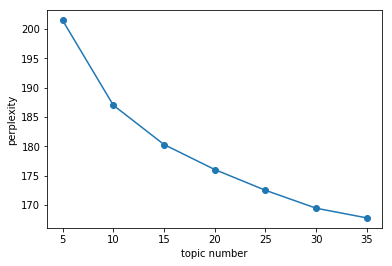

In [23]:
topics_num = [5,10,15,20,25,30,35]
perplexity_array = [201.51309228186344,187.02964688607923,180.31479669874173,176.04686564166764,172.5083842791524,169.44647660180442,167.794412854037]

plt.plot(topics_num, perplexity_array, marker='o')
plt.xlabel('topic number')
plt.ylabel('perplexity')
plt.show()